<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
%load_ext autoreload
%autoreload 2
from matplotlib.lines import Line2D
import qgrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
from enm.visualize.visualize import plot_correlation_density, plot_vector, plot_lambda_collectivity
from enm.enm import Enm
from enm.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
%load_ext rpy2.ipython


/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
os.chdir('../')

In [157]:
with open(f'data/interim/pcc_0909/pcc.pickle','rb') as f:
    e_pcc = pickle.load(f)



In [158]:
sensors_pcc = e_pcc.df.loc[e_pcc.df.sens>np.quantile(e_pcc.df.sens,0.99)]
sensor_sub_pcc = get_subnetwork(e_pcc.graph_gc, sensors_pcc.orf_name.values)
is_sensor = dict(zip(sensor_sub_pcc.nodes, [True if i in sensors_pcc.orf_name.values else False  for i in sensor_sub_pcc.nodes]))
nx.set_node_attributes(sensor_sub_pcc, is_sensor, 'is_sensor')
sensor_go_terms_separate = [
    'iron ion\ntransport',
    'phenylalanine\ntransport',
    None, 
    None,
    None,
    None,
    'tricarboxylic\nacid cycle', 
    'hexose metabolic\nprocess',
    'protein folding',
    'mitochondria-nucleus\nsignaling pathway/TCA',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]
sensor_connected_components = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name))], key=lambda x: x[0])
sensor_go_terms= {}
for i in range(len(sensor_go_terms_separate)):
    for j in sensor_connected_components[i]:
        sensor_go_terms[j] = sensor_go_terms_separate[i]

In [159]:
sensors_pcc = sensors_pcc.merge(pd.DataFrame.from_dict(sensor_go_terms,orient='index',columns=['go_group']),right_index=True,left_on='orf_name')

In [75]:
nds = [[nx.ego_graph(e_pcc.graph_gc,i,1).nodes for i in j] for j in sensor_connected_components if len(j)>2]


In [80]:
nds_sub = [nds[i] for i in [0,1,2,3,6,8]]

In [163]:
fig, ax = plt.subplots(2,3,figsize=(12,12))
axs = ax.ravel()
for i in range(len(nds_sub)):
    sub = nx.induced_subgraph(e_pcc.graph_gc,np.unique([i for sublist in nds_sub[i] for i in sublist ]))
    nx.draw(sub, 
            ax=axs[i], pos=pos,
           node_color =['red' if i in sensors_pcc.orf_name.tolist() else 'blue' for i in sub.nodes ])
    #for t in sub.nodes:
     #   del sub.nodes[t]['pos']
#    nx.write_graphml(sub, f'data/interim/sensor_antenna/{i}.graphml')

plt.savefig(f'reports/figures/sensor_antenna/antennafig.png')

In [91]:
%%R -o col
library(RColorBrewer)
col <- brewer.pal(n=9,name='Set1')

In [98]:
sensor_go_terms

{'aft1': 'iron ion\ntransport',
 'fet3': 'iron ion\ntransport',
 'ymr057c': 'iron ion\ntransport',
 'agp1': 'phenylalanine\ntransport',
 'bap2': 'phenylalanine\ntransport',
 'dal81': 'phenylalanine\ntransport',
 'rma1': 'phenylalanine\ntransport',
 'stp1': 'phenylalanine\ntransport',
 'stp2': 'phenylalanine\ntransport',
 'akr2': None,
 'ypr039w': None,
 'apt2': None,
 'inm1': None,
 'ypl109c': None,
 'csm2': None,
 'tpo4': None,
 'erv46': None,
 'fbp1': 'tricarboxylic\nacid cycle',
 'fum1': 'tricarboxylic\nacid cycle',
 'sdh5': 'tricarboxylic\nacid cycle',
 'gal7': 'hexose metabolic\nprocess',
 'sip4': 'hexose metabolic\nprocess',
 'ycr062w': 'hexose metabolic\nprocess',
 'hsc82': 'protein folding',
 'ram1-supp1': 'protein folding',
 'sti1': 'protein folding',
 'idh1': 'mitochondria-nucleus\nsignaling pathway/TCA',
 'idh2': 'mitochondria-nucleus\nsignaling pathway/TCA',
 'irc14': 'mitochondria-nucleus\nsignaling pathway/TCA',
 'mks1-supp1': 'mitochondria-nucleus\nsignaling pathway/TCA'

In [237]:
col

array(['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33',
       '#A65628', '#F781BF', '#999999'], dtype='<U7')

In [247]:
sensor_colors = col[0:6]
effector_colors=col[6:9]

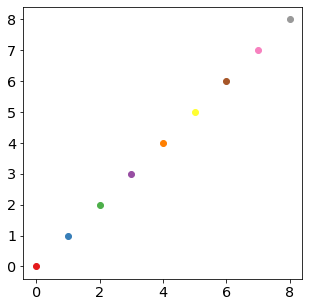

In [97]:
for i in range(9):
    plt.scatter(i,i,c=col[i])

In [114]:
sensor_order = sensors_pcc.groupby('go_group').sens.median().sort_values().index.tolist()

In [160]:
#e_pcc.spring_pos()
pos = e_pcc.graph_gc.nodes('pos')

In [208]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
e_pcc.plot_network_spring(ax=ax,
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black',savefig=False)
    #                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
    # nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
    #                           node_color='black',
    #                           node_shape='^',edgecolors='black',
    #                           linewidths=1)
nx.draw_networkx_nodes(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()),
                       pos=pos, 
                       node_color='black', alpha=1, node_shape='^')

for itr, i in enumerate(sensor_order):
    #print(i, effector_colors[itr])

    orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                          node_color=sensor_colors[itr],
                          node_shape='^',edgecolors='black',
                          linewidths=1)
    legend_elements.append(
        Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
                              markerfacecolor=sensor_colors[itr], markersize=30, linestyle="None")
    )
ax.set_facecolor('white')
legend_elements.append(
        Line2D([0], [0], marker='^', color='black', label=f'Sensors (No GO Enrichments )',
                              markerfacecolor='black', markersize=30, linestyle="None")
    )
legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5, lw=10),
                   Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-",lw=10)
                   #Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
    #                          markerfacecolor='#a6611a', markersize=0, linestyle="-")
    ]
)
#lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5),ncol=5)
nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()),pos=pos, edge_color='red', alpha=0.5)

#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
plt.savefig('reports/figures/network_images_040221/tmp_nw_sens.png',bbox_inches='tight')

In [211]:
fig = plt.figure()
figlegend = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=legend_elements, fontsize=40, loc='center',ncol=2)
fig.show()
#figlegend.show()
fig.savefig('reports/figures/network_images_040221/tmp_nw_sens_legend.png',bbox_inches='tight')


<Figure size 144x144 with 0 Axes>

In [222]:
legend_elements_subplots =[legend_elements[i] for i in [1,3,4,5,6]]
legend_elements_subplots.extend([
    Line2D([0], [0], marker='o', color='black', label='Sensor to network connection node',
                              markerfacecolor='black', markersize=30, linestyle="None"),
    Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=1, lw=10)
    
])

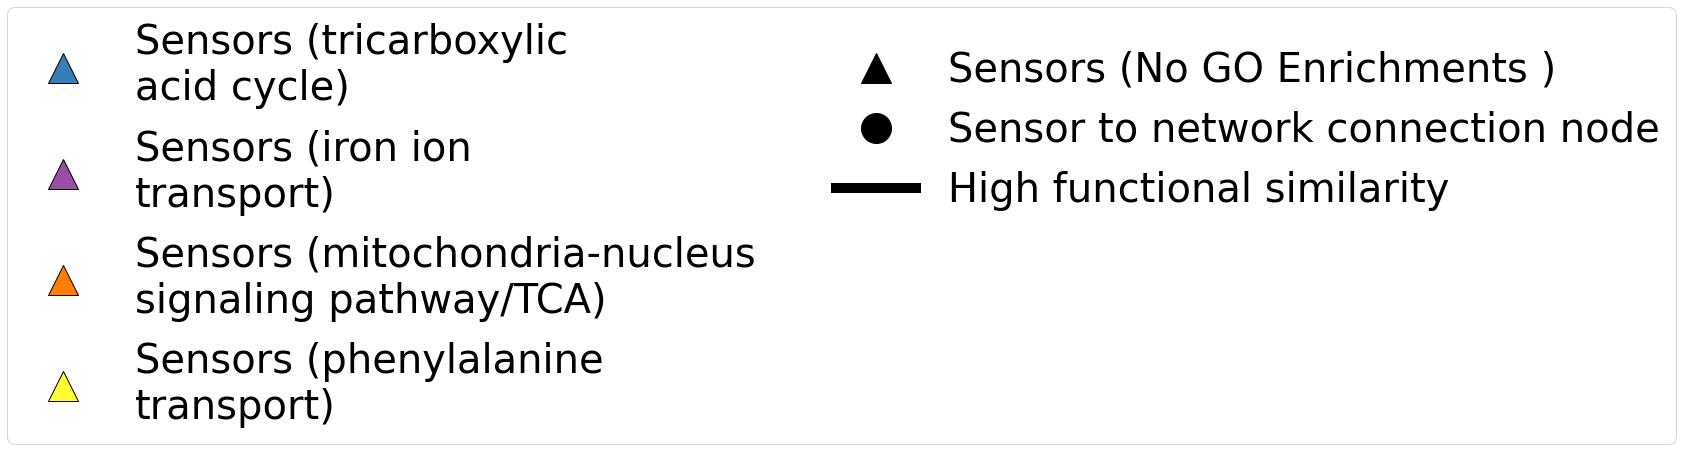

<Figure size 144x144 with 0 Axes>

In [224]:
fig = plt.figure()
figlegend = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=legend_elements_subplots, fontsize=40, loc='center',ncol=2)
fig.show()
#figlegend.show()
fig.savefig('reports/figures/network_images_040221/sub_plot_legend.png',bbox_inches='tight')


In [168]:
fig, ax = plt.subplots(3,2,figsize=(10,15))
axs = ax.ravel()
legend_elements = [    ]

for i in range(len(sensor_order)):
    nx.draw_networkx_nodes(e_pcc.graph_gc,ax=axs[i], pos = pos,
                              node_size=0.5,
                              alpha=0.2,
                              node_color='black'
     #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                             #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                             )
    #                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
    # nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
    #                           node_color='black',
    #                           node_shape='^',edgecolors='black',
    #                           linewidths=1)
   # nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()), ax=axs[i] , pos=pos, edge_color='red', alpha=0.5)
    axs[i].set_facecolor('white')
for i in range(len(nds_sub)):
    sub = nx.induced_subgraph(e_pcc.graph_gc,np.unique([i for sublist in nds_sub[i] for i in sublist ]))
    nx.draw(sub, 
            ax=axs[i], pos=pos,node_shape='^',edgecolors='black',
           node_color =['red' if i in sensors_pcc.orf_name.tolist() else 'blue' for i in sub.nodes ])
# for itr, i in enumerate(sensor_order):
#     #print(i, effector_colors[itr])

#     orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
#     sub = nx.induced_subgraph(e_pcc.graph_gc, orf_names_to_plot)
#     nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
#                           node_color=sensor_colors[itr],
#                           node_shape='^',edgecolors='black',
#                           linewidths=1, ax = axs[itr])
#     nx.draw_networkx_edges(e_pcc.graph_gc, edgelist=sub.edges(), node_size=200, pos=pos, edge_color='red',
# #                          node_color=sensor_colors[itr],
#  #                         node_shape='^',edgecolors='black',
#                            ax = axs[itr])
#     legend_elements.append(
#         Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
#                               markerfacecolor=sensor_colors[itr], markersize=12, linestyle="None")
#     )

legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Genes',
                              markerfacecolor='black', markersize=4, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
                              markerfacecolor='#a6611a', markersize=0, linestyle="-")]
)
#lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))

#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('tmp_nw.png',bbox_inches='tight')

In [183]:
effector_pcc = e_pcc.df.loc[e_pcc.df.eff>np.quantile(e_pcc.df.eff,0.99)]
effectors_connected_comp = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()))], key=lambda x:x[0])
effector_pcc.loc[:, 'go_group'] = ['Respiratory complex assembly' if i in effectors_connected_comp[0] else 'Golgi vesicle transport' if i in effectors_connected_comp[1] else 'Chromosome segragation' for i in effector_pcc.orf_name]
effector_order = effector_pcc.groupby('go_group').eff.median().sort_values().index.tolist()

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [233]:
effector_order

['Chromosome segragation',
 'Golgi vesicle transport',
 'Respiratory complex assembly']

In [255]:
labels=['Chromosome\nsegregation',
 'Golgi vesicle\ntransport',
 'Respiratory\ncomplex assembly']

In [256]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
e_pcc.plot_network_spring(ax=ax,
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black',savefig=False)
    #                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
    # nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
    #                           node_color='black',
    #                           node_shape='^',edgecolors='black',
    #                           linewidths=1)

for itr, i in enumerate(effector_order):
   # print(i, effector_colors[itr])
    #print(itr)
    
    orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i, 'orf_name'].tolist()
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                          node_color=col[itr+6],
                          node_shape='o',edgecolors='black',
                          linewidths=1)
    legend_elements.append(
        Line2D([0], [0], marker='o', color='black', label=f'Effectors ({labels[itr]})',
                              markerfacecolor=effector_colors[itr], markersize=30, linestyle="None")
    )
ax.set_facecolor('white')
legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10),
                   Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
                             markerfacecolor='#a6611a', markersize=0, linestyle="-",lw=10)
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))


nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
#plt.savefig('reports/figures/network_images_040221/tmp_nw_eff.png',bbox_inches='tight')

In [257]:
fig = plt.figure()
figlegend = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111)
#lines = ax.plot(range(10), plt.randn(10), range(10), plt.randn(10))
ax.axis('off')
lgd = ax.legend(handles=legend_elements, fontsize=40, loc='center',ncol=1)
fig.show()
#figlegend.show()
fig.savefig('reports/figures/network_images_040221/tmp_nw_eff_legend.png',bbox_inches='tight')


<Figure size 144x144 with 0 Axes>

In [259]:
with open(f'data/interim/pcc_021521_withclustering/pcc_10.pickle','rb') as f:
    e_pcc_cl = pickle.load(f)


In [262]:
pos = e_pcc.graph_gc.nodes('pos')

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,...,Systematic gene name,Allele Gene name,num,cat,bin,group,cat_,effector_cluster,go_group,go_term
1661,tub3,51,-0.007501,-0.000807,-0.000476,0.002077,-0.000209,0.001395,-0.015312,0.001126,...,YML124C,tub3,8130,na.nq,82,nonessential,Nonessential\nquery and array,1,None,DNA replication
1206,hcm1,61,-0.007531,-0.000582,-0.000192,0.003171,0.002185,0.005049,-0.017705,0.001827,...,YCR065W,hcm1,7600,na.nq.nxes,76,nonessential,Nonessential\nquery and array,1,None,DNA replication
2309,cin2,61,-0.005991,-0.000975,-0.000298,0.001034,0.000282,0.001012,-0.012696,0.002950,...,YPL241C,cin2,8726,na.nq.nxes,88,nonessential,Nonessential\nquery and array,1,None,DNA replication
2308,cin1,67,-0.005894,-0.001097,-0.000042,0.000769,0.000541,0.001526,-0.012729,0.001593,...,YOR349W,cin1,8677,na.nq.nxes,87,nonessential,Nonessential\nquery and array,1,None,DNA replication
269,stu2-11,67,-0.005042,-0.000671,0.000126,0.000662,0.000157,0.001275,-0.010460,0.002141,...,YLR045C,stu2-11,7478,essential,75,essential,Essential,1,None,DNA replication
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,keg1-5002-supp1,62,-0.000492,-0.007665,0.001233,-0.000004,-0.000776,0.000134,0.000079,0.004247,...,YFR042W,keg1-5002-supp1,4309,essential,44,essential,Essential,1,None,DNA replication
1127,mnn2,64,-0.000230,-0.009021,0.000416,-0.000256,-0.000424,-0.000488,0.000227,0.003138,...,YBR015C,mnn2,8703,na.nq.nxes,88,nonessential,Nonessential\nquery and array,1,None,DNA replication
1104,cne1,66,-0.000436,-0.008861,0.001469,-0.000353,-0.000557,-0.000595,0.000598,0.004227,...,YAL058W,cne1,8941,na.nq.nxes,90,nonessential,Nonessential\nquery and array,1,None,DNA replication
1073,gwt1-20,66,-0.000439,-0.009090,0.001770,-0.000300,-0.000817,-0.000552,0.000811,0.004467,...,YJL091C,gwt1-20,7541,essential,76,essential,Essential,1,None,DNA replication


In [298]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
nx.draw_networkx_nodes(e_pcc_cl.graph_gc, ax =ax , pos=pos,node_size=1, node_color='black')
nx.draw_networkx_edges(e_pcc_cl.graph_gc, ax =ax , pos=pos,node_size=1, edge_color='black',alpha=0.2, width=0.1)
nx.draw_networkx_nodes(e_pcc_cl.graph_gc, 
                       nodelist=e_pcc_cl.effectors_df.orf_name.tolist(),
                       ax=ax, 
                       pos=pos,
                       node_color='orangered',
                      edgecolors='black',
                      node_size=100,
                      node_shape='d')

ax.set_facecolor('white')
legend_elements.extend(
    [Line2D([0], [0], marker='d', color='black', label='Row cluster\ngenes',
                              markerfacecolor='orangered', markersize=50, linestyle="None"),
     Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=25, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High\nfunctional\nsimilarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10)
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=40,loc='center left', bbox_to_anchor=(1.1, 0.5))


#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
plt.savefig('reports/figures/network_images_040221/rowcluster_nw_map.png',bbox_inches='tight')

In [299]:
fig, ax = plt.subplots(figsize=(12,12))
#axs = ax.ravel()
legend_elements = [    ]

#for i in range(len(sensor_order)):
nx.draw_networkx_nodes(e_pcc_cl.graph_gc, ax =ax , pos=pos,node_size=1, node_color='black')
nx.draw_networkx_edges(e_pcc_cl.graph_gc, ax =ax , pos=pos,node_size=1, edge_color='black',alpha=0.2, width=0.1)
nx.draw_networkx_nodes(e_pcc_cl.graph_gc, 
                       nodelist=e_pcc_cl.sensors_df.orf_name.tolist(),
                       ax=ax, 
                       pos=pos,
                       node_color='orange',
                      edgecolors='black',
                      node_size=100,
                      node_shape='D')

ax.set_facecolor('white')
legend_elements.extend([
    Line2D([0], [0], marker='D', color='black', label='Column cluster\ngenes',
                              markerfacecolor='orange', markersize=50, linestyle="None"),
    Line2D([0], [0], marker='o', color='black', label='Other Genes',
                              markerfacecolor='black', markersize=25, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High\nfunctional\nsimilarity',
                              markerfacecolor='black', markersize=0, linestyle="-", alpha=0.5,lw=10),
    ]
)
lgd = ax.legend(handles=legend_elements, fontsize=40,loc='center left', bbox_to_anchor=(1.1, 0.5))


#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax , pos=pos, edge_color='blue',alpha=0.5)
plt.savefig('reports/figures/network_images_040221/colcluster_nw_map.png',bbox_inches='tight')

In [302]:
cc = e_pcc_cl.sensors_df
rc = e_pcc_cl.effectors_df

In [305]:
#rc: row cluster
#cc: column cluster

In [306]:
df = e_pcc.df
df['cc'] = ['cc' if i in cc.orf_name.tolist() else 'other' for i in df.orf_name.tolist()]
df['rc'] = ['rc' if i in rc.orf_name.tolist() else 'other' for i in df.orf_name.tolist()]

Text(0, 0.5, 'Sensitivity')

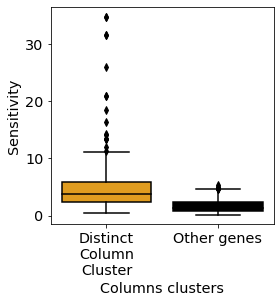

In [331]:
import seaborn as sns
color = {'cc': 'orange','other':'k','rc':'orangered'}
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data=df, x='cc',y='sens',order=['cc','other'],palette=color)
ax.set_xticklabels(['Distinct\nColumn\nCluster', 'Other genes'])
ax.set_xlabel('Columns clusters')
ax.set_ylabel('Sensitivity')
plt.savefig('reports/figures/network_images_040221/colcluster_sens.png')

Text(0, 0.5, 'Effectiveness')

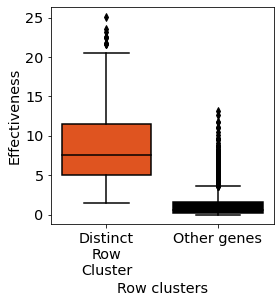

In [332]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(4,4))
sns.boxplot(data=df, x='rc',y='eff',order=['rc','other'],palette=color)
ax.set_xticklabels(['Distinct\nRow\nCluster', 'Other genes'])
ax.set_xlabel('Row clusters')
ax.set_ylabel('Effectiveness')
plt.savefig('reports/figures/network_images_040221/rowcluster_eff.png')